In [30]:
import numpy as np
import os
import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Ellipse
import matplotlib.cm as cm
import warnings
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter1d
from matplotlib.lines import Line2D
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
from collections import Counter
from matplotlib.ticker import FixedLocator
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import random
from scipy.stats import ttest_ind
warnings.filterwarnings("ignore", category=UserWarning)

In [31]:
full_path = 'C:\\Users\\RJEN0307\\Desktop\\Rasmus, Bachelorprojekt\\Data\\1_csv'

patient_numbers = []
patient_data = {}

for file in os.listdir(full_path):
    filename = os.fsdecode(file)
    patient_number = filename.split('_')[0] 
    patient_numbers.append(patient_number)
    patient_file_dir = os.path.join(full_path, filename)
    data = pd.read_csv(patient_file_dir)

    data.rename(columns={'Unnamed: 0': 'Index'}, inplace=True)
    data['Event'] = data['Event'].map({'R': 0, 'M': 1, 'F': 2})

    columns_to_remove = [col for col in data.columns if '_N' in col]
    data = data.drop(columns=columns_to_remove)

    resting_data = data[data['Event'] == 0]
    moving_data = data[data['Event'] == 1]
    familiar_data = data[data['Event'] == 2]
    target_count = min(moving_data.shape[0], familiar_data.shape[0])
    resting_data = resting_data.iloc[-target_count:]
    resting_data = resting_data.reset_index(drop=True)
    moving_data = moving_data.reset_index(drop=True)
    familiar_data = familiar_data.reset_index(drop=True)
    balanced_data = pd.concat([resting_data, moving_data, familiar_data]).reset_index(drop=True)

    standarize_list = ['PSD Delta', 'PSD Theta',  'PSD Alpha', 'PSD Beta', 'PSD Gamma', 'PSD SE', 'PSD MSF', 'PSD Sef90', 'PSD Sef95', 'PE', 'wSMI', 'Kolmogorov', 'Freq_Slope mean', 'Freq_Slope std']
    
    #standarize_list =  ['PSD Delta', 'PSD Theta', 'PSD Alpha', 'PSD Beta', 'PSD Gamma']

    scaler = StandardScaler()
    balanced_data[standarize_list] = scaler.fit_transform(balanced_data[standarize_list])
    patient_data[patient_number] = balanced_data
    
    # show patient 10
    print(patient_data['p10'].head())

   Index  Event  PSD Delta  PSD Theta  PSD Alpha  PSD Beta  PSD Gamma  \
0   1500      0  -0.504771  -1.555079  -1.113242 -0.866272  -0.493307   
1   1501      0  -1.207551  -1.285578  -0.421632 -0.046604  -0.189003   
2   1502      0   2.094303  -0.218608  -0.972915 -1.282925  -0.468644   
3   1503      0   1.165314  -0.893731   0.395907 -1.449045  -1.025031   
4   1504      0  -0.710573  -0.297616  -1.010877 -0.883369  -1.267831   

     PSD SE   PSD MSF  PSD Sef90  PSD Sef95        PE      wSMI  Kolmogorov  \
0 -0.208458 -0.717660  -0.079449   0.452049 -0.135324 -0.296510    0.232978   
1  0.559548 -0.149165   0.738750   0.735636 -0.360464 -0.265355    0.580077   
2 -1.750320 -1.018849  -1.755760  -1.873936 -2.154975  0.022672   -0.688630   
3 -1.174411 -1.146854  -0.959331  -0.805472 -0.276526 -0.767685   -0.604848   
4  0.104931 -0.145400  -0.161088   0.230050 -0.436271 -0.012307    0.867331   

   Freq_Slope mean  Freq_Slope std  
0        -0.428410        0.710905  
1         1.

Most common number of PCA components explaining 95% variance: 8


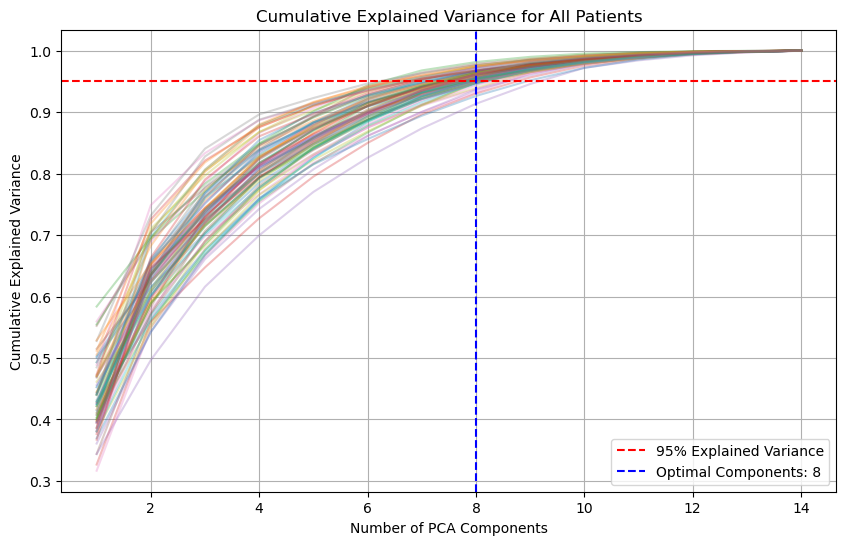

In [32]:
# Define PCA analysis function
def find_optimal_pca_components(patient_data):
    component_counts = []
    cumulative_variances = []
    for patient, data in patient_data.items():
        features = data.drop(columns=[col for col in ['Event'] if col in data.columns])
        # drop Index column
        features = features.drop(columns=[col for col in ['Index'] if col in features.columns])

        pca = PCA()
        pca.fit(features)
        cumulative_variance = pca.explained_variance_ratio_.cumsum()
        cumulative_variances.append(cumulative_variance)
        n_components = next(i for i, v in enumerate(cumulative_variance) if v >= 0.95) + 1
        component_counts.append(n_components)

    most_common_components = Counter(component_counts).most_common(1)[0][0]
    return most_common_components, component_counts, cumulative_variances

# Perform PCA analysis
most_common_components, component_counts, cumulative_variances = find_optimal_pca_components(patient_data)
print(f"Most common number of PCA components explaining 95% variance: {most_common_components}")

# Plot cumulative variance for all patients
plt.figure(figsize=(10, 6))
for cumulative_variance in cumulative_variances:
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, alpha=0.3)
plt.xlabel('Number of PCA Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance for All Patients')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.axvline(x=most_common_components, color='b', linestyle='--', label=f'Optimal Components: {most_common_components}')
plt.grid()
plt.legend()
plt.show()


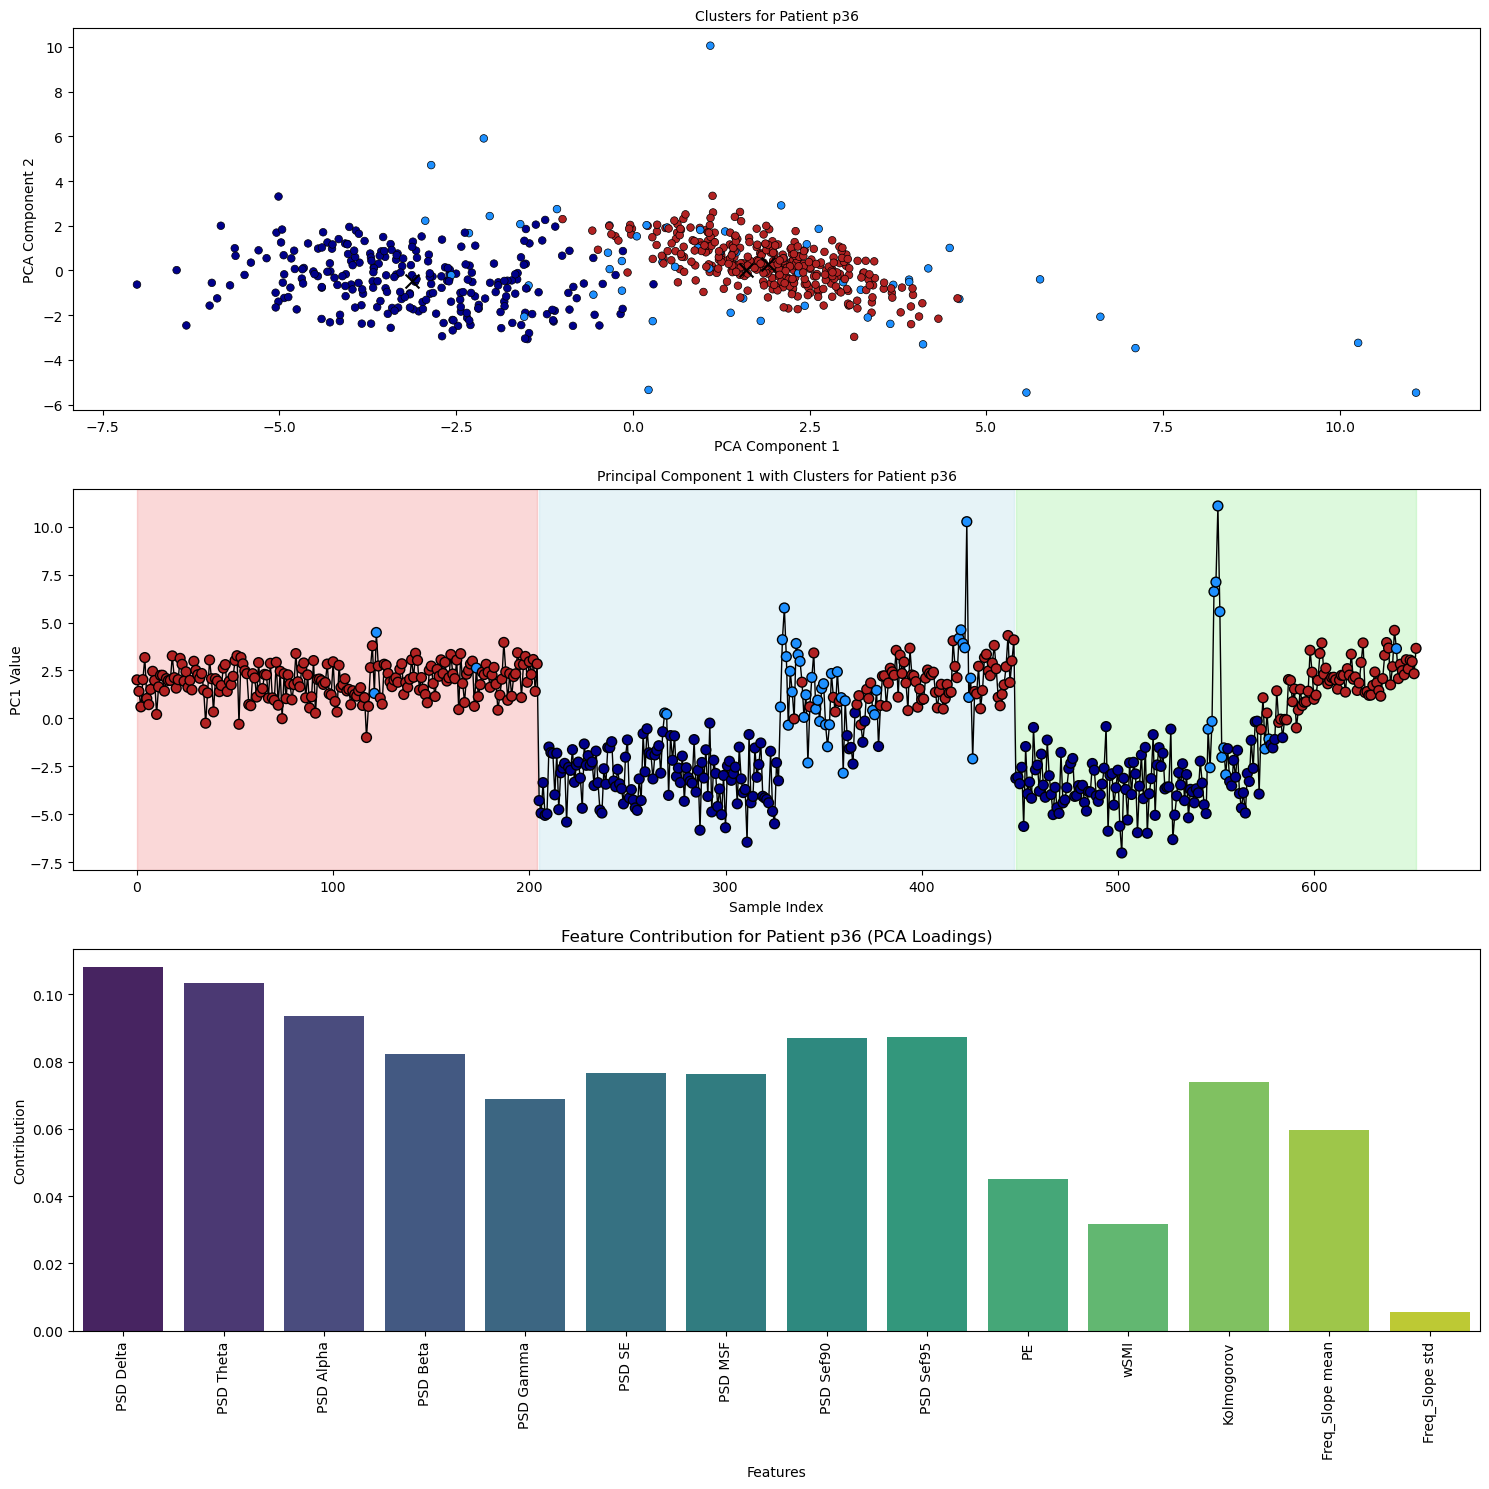

In [33]:
def combined_plot_for_each_patient(patient_data, patients, n_components_pca=5, n_components_gmm=3, save_to_pdf=False, output_pdf_path='combined_patient_plots_final.pdf', contribution_pdf_path='feature_contribution_plot.pdf',output_pca_path = 'PCAplot_1',pca_plot = False,feature_importance=False):
    feature_names = ['PSD Delta', 'PSD Theta', 'PSD Alpha', 'PSD Beta', 'PSD Gamma', 'PSD SE', 'PSD MSF', 'PSD Sef90', 'PSD Sef95', 'PE', 'wSMI', 'Kolmogorov', 'Freq_Slope mean', 'Freq_Slope std']
    #feature_names =  ['PSD Delta', 'PSD Theta', 'PSD Alpha', 'PSD Beta', 'PSD Gamma']
    
    if save_to_pdf:
        pdf = PdfPages(output_pdf_path)
    
    feature_importance_count = {feature: 0 for feature in feature_names}
    all_pca_data = []
    all_patient_labels = []

    
    for patient in patients:
        data = patient_data[patient].copy()

        data_for_pca = data.drop(columns=['Index','Event'])

        pca = PCA(n_components=n_components_pca)
        reduced_data = pca.fit_transform(data_for_pca)
        pca_df = pd.DataFrame(reduced_data, columns=[f'PC{i+1}' for i in range(n_components_pca)])

        all_pca_data.append(pca_df)
        all_patient_labels.extend([patient] * len(reduced_data))
        
        
        gmm = GaussianMixture(n_components=n_components_gmm, random_state=0)
        gmm.fit(reduced_data)
        labels = gmm.predict(reduced_data)
        
        feature_contributions = np.sum(np.abs(pca.components_[:2]), axis=0)
        feature_contributions /= np.sum(feature_contributions)

        if len(feature_contributions) != len(feature_names):
            feature_contributions = feature_contributions[:len(feature_names)]

        importance_threshold = np.percentile(feature_contributions, 75)

        for idx, contribution in enumerate(feature_contributions):
            if contribution >= importance_threshold:
                feature_importance_count[feature_names[idx]] += 1

        patient_data_with_labels = data.copy()
        patient_data_with_labels['Cluster Label'] = labels

        fig, axes = plt.subplots(3, 1, figsize=(15, 15))
        
        ax = axes[0]
        cluster_colors = ['firebrick' if label == 0 else 'darkblue' if label == 1 else 'dodgerblue' for label in labels]


        scatter = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_colors, marker='o', edgecolor='black', linewidth=0.5, s=30)
        ax.scatter(gmm.means_[:, 0], gmm.means_[:, 1], s=100, c='black', marker='x', label='Cluster Means')
        ax.set_title(f"Clusters for Patient {patient}", fontsize=10)
        ax.set_xlabel('PCA Component 1')
        ax.set_ylabel('PCA Component 2')
        ax.grid(False)
        
        ax2 = axes[1]
        time = np.arange(len(patient_data_with_labels))

        # Use PC1 as the y-axis
        ax2.plot(time, reduced_data[:, 0], label='PC1 (Principal Component 1)', color='black', linewidth=1)

        ax2.scatter(time, reduced_data[:, 0], c=cluster_colors, s=50, edgecolor='black', label='Cluster Data Points (PC1)', zorder=3)

        stimuli_colors = {0: 'lightcoral', 1: 'lightblue', 2: 'lightgreen'}  # 0=R, 1=M, 2=F

        event_groups = patient_data_with_labels['Event'].ne(patient_data_with_labels['Event'].shift()).cumsum()

        for _, group_data in patient_data_with_labels.groupby(event_groups):
            stimulus_value = group_data['Event'].iloc[0]
            if stimulus_value in stimuli_colors:
                start_idx = group_data.index[0]
                end_idx = group_data.index[-1]
                start_time = time[start_idx]
                end_time = time[end_idx]
                ax2.axvspan(start_time, end_time, color=stimuli_colors[stimulus_value], alpha=0.3, zorder=1)

        ax2.set_title(f'Principal Component 1 with Clusters for Patient {patient}', fontsize=10)
        ax2.set_xlabel('Sample Index')
        ax2.set_ylabel('PC1 Value')
        ax2.grid(False)

        ax3 = axes[2]
        sns.barplot(x=feature_names[:len(feature_contributions)], y=feature_contributions, palette='viridis', ax=ax3, hue=feature_names[:len(feature_contributions)], legend=False)
        ax3.xaxis.set_major_locator(FixedLocator(range(len(feature_names[:len(feature_contributions)]))))
        ax3.set_xticklabels(feature_names[:len(feature_contributions)], rotation=90)
        ax3.set_xlabel('Features')
        ax3.set_ylabel('Contribution')
        ax3.set_title(f'Feature Contribution for Patient {patient} (PCA Loadings)')
        

        plt.tight_layout()
        
        if save_to_pdf:
            pdf.savefig(fig)
            plt.close(fig)
        else:
            plt.show()

    if save_to_pdf:
        pdf.close()

    if feature_importance:
        plt.figure(figsize=(10, 6))
        sns.barplot(x=list(feature_importance_count.keys()), y=list(feature_importance_count.values()), palette='viridis', hue=list(feature_importance_count.keys()), legend=False)

        plt.xlabel('Features')
        plt.ylabel('Count of Importance')
        plt.title('Feature Importance Count Across All Patients')
        plt.xticks(rotation=90)
        plt.tight_layout()

        if save_to_pdf:
            plt.savefig(contribution_pdf_path)
            plt.close()
        else:
            plt.show()
    else:
        plt.show()

    if pca_plot:
        combined_pca_df = pd.concat(all_pca_data, ignore_index=True)
        combined_pca_df['Patient'] = all_patient_labels
        pair_plot = sns.pairplot(combined_pca_df, hue='Patient', height=1.5, aspect=1, plot_kws={'s': 10}, diag_kind='hist')
        pair_plot._legend.remove()
        plt.suptitle("Combined PCA Pair Plot for All Patients", y=1.02)

        pca_image_path = output_pca_path.replace('.pdf', '_temp.png')
        pair_plot.savefig(pca_image_path, dpi=300, bbox_inches='tight')
        plt.show() 
        plt.close()

        if save_to_pdf:
            with PdfPages(output_pca_path) as pdf:
                img = plt.imread(pca_image_path)
                img_height, img_width = img.shape[0:2]
                fig, ax = plt.subplots(figsize=(img_width / 100, img_height / 100)) 
                ax.imshow(img)
                ax.axis('off') 
                pdf.savefig(fig, bbox_inches='tight') 
                plt.close(fig)

        if os.path.exists(pca_image_path):
            os.remove(pca_image_path)


patients = ['p36']

# Example
combined_plot_for_each_patient(patient_data, patients, n_components_pca=8, n_components_gmm=3, feature_importance=False, pca_plot=False)

# Render and export all
#combined_plot_for_each_patient(patient_data, patients, n_components_pca=8, n_components_gmm=3, save_to_pdf=True, feature_importance=True, pca_plot=True, output_pdf_path='PDF files\\All features\\Patientplots_1.pdf', contribution_pdf_path='PDF files\\All features\\Featureplots_1.pdf',output_pca_path = 'PDF files\\All features\\PCAplots_1.pdf')


In [34]:
def calculate_silhouette_scores(patient_data, patients, n_components_pca=8, n_components_gmm=3):
    silhouette_scores = {}

    for patient in patients:
        data = patient_data[patient].copy()
        data_for_pca = data.drop(columns=['Event'])
        data_for_pca = data_for_pca.drop(columns=[col for col in ['Index'] if col in data_for_pca.columns])

        pca = PCA(n_components=n_components_pca)
        reduced_data = pca.fit_transform(data_for_pca)

        gmm = GaussianMixture(n_components=n_components_gmm, random_state=0)
        gmm.fit(reduced_data)
        labels = gmm.predict(reduced_data)

        if len(set(labels)) > 1:
            silhouette_avg = silhouette_score(reduced_data, labels)
            silhouette_scores[patient] = silhouette_avg
        else:
            silhouette_scores[patient] = None

    print("Silhouette Scores:")
    for patient, score in silhouette_scores.items():
        if score is not None:
            print(f"Patient {patient}: {score:.2f}")
        else:
            print(f"Patient {patient}: Could not be computed (single cluster).")

    valid_scores = [score for score in silhouette_scores.values() if score is not None]

    percentile_85 = np.percentile(valid_scores, 85) if valid_scores else None

    patients_in_85th_percentile = [
        patient for patient, score in silhouette_scores.items()
        if score is not None and score >= percentile_85
    ] if percentile_85 is not None else []

    if percentile_85 is not None:
        print(f"\n85th Percentile of Silhouette Scores: {percentile_85:.2f}")
        print("Patients in the 85th Percentile:")
        for patient in patients_in_85th_percentile:
            print(f"Patient {patient}")
    else:
        print("\n85th Percentile of Silhouette Scores: Not enough valid scores to compute.")

    return silhouette_scores, percentile_85, patients_in_85th_percentile

patients = patient_data.keys()
silhouette_scores, percentile_85, patients_in_85th_percentile = calculate_silhouette_scores(patient_data, patients, n_components_pca=8, n_components_gmm=3)


Silhouette Scores:
Patient p10: 0.17
Patient p11: 0.38
Patient p12: 0.12
Patient p13: 0.21
Patient p14: 0.11
Patient p15: 0.21
Patient p16: 0.13
Patient p17: 0.16
Patient p18: 0.13
Patient p19: 0.30
Patient p20: 0.11
Patient p21: 0.20
Patient p22: 0.12
Patient p23: 0.22
Patient p24: 0.16
Patient p25: 0.25
Patient p27: 0.12
Patient p28: 0.15
Patient p29: 0.23
Patient p2: 0.13
Patient p30: 0.15
Patient p31: 0.17
Patient p32: 0.24
Patient p33: 0.18
Patient p34: 0.25
Patient p35: 0.26
Patient p36: 0.39
Patient p37: 0.21
Patient p38: 0.28
Patient p39: 0.19
Patient p3: 0.18
Patient p40: 0.17
Patient p41: 0.14
Patient p42: 0.15
Patient p43: 0.11
Patient p44: 0.20
Patient p45: 0.22
Patient p46: 0.30
Patient p47: 0.16
Patient p48: 0.11
Patient p49: 0.17
Patient p4: 0.25
Patient p50: 0.21
Patient p51: 0.25
Patient p52: 0.19
Patient p53: 0.19
Patient p54: 0.16
Patient p56: 0.33
Patient p57: 0.15
Patient p58: 0.11
Patient p59: 0.20
Patient p5: 0.17
Patient p60: 0.13
Patient p61: 0.18
Patient p62: 

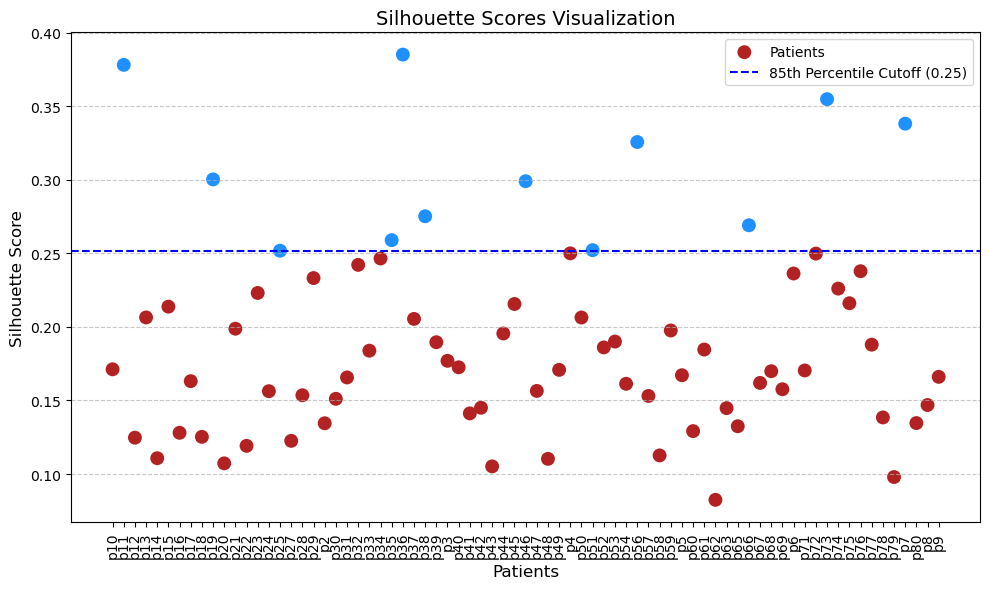

In [35]:
def visualize_silhouette_scores(silhouette_scores, percentile_cutoff=85):
    valid_scores = {patient: score for patient, score in silhouette_scores.items() if score is not None}

    scores = list(valid_scores.values())
    cutoff_value = np.percentile(scores, percentile_cutoff)

    responders = {patient: score for patient, score in valid_scores.items() if score >= cutoff_value}
    non_responders = {patient: score for patient, score in valid_scores.items() if score < cutoff_value}

    plt.figure(figsize=(10, 6))

    colors = ['dodgerblue' if score >= cutoff_value else 'firebrick' for score in valid_scores.values()]
    plt.scatter(
        list(valid_scores.keys()),
        list(valid_scores.values()),
        c=colors,
        s=100,
        edgecolor='black',
        label='Patients',
        linewidths=0
    )

    plt.axhline(y=cutoff_value, color='blue', linestyle='--', label=f'85th Percentile Cutoff ({cutoff_value:.2f})')
    plt.title('Silhouette Scores Visualization', fontsize=14)
    plt.xlabel('Patients', fontsize=12)
    plt.ylabel('Silhouette Score', fontsize=12)
    plt.xticks(rotation=90)
    plt.legend(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    plt.show()


visualize_silhouette_scores(silhouette_scores, percentile_cutoff=85)


In [36]:
def t_test_responder_analysis(silhouette_scores, percentile_cutoff=85):
    valid_scores = {patient: score for patient, score in silhouette_scores.items() if score is not None}

    cutoff_value = np.percentile(list(valid_scores.values()), percentile_cutoff)

    responders = [score for score in valid_scores.values() if score >= cutoff_value]
    non_responders = [score for score in valid_scores.values() if score < cutoff_value]

    t_stat, p_value = ttest_ind(responders, non_responders, equal_var=False)

    responders_mean = np.mean(responders) if responders else None
    non_responders_mean = np.mean(non_responders) if non_responders else None

    print("T-Test Results:")
    print(f"Responders Mean (85th Percentile and above): {responders_mean:.2f}")
    print(f"Non-Responders Mean (below 85th Percentile): {non_responders_mean:.2f}")
    print(f"T-Statistic: {t_stat:.2f}")
    print(f"P-Value: {p_value:.4f}")

    return {
        "responders_mean": responders_mean,
        "non_responders_mean": non_responders_mean,
        "t_statistic": t_stat,
        "p_value": p_value
    }


t_test_responder_analysis(silhouette_scores, percentile_cutoff=85)

T-Test Results:
Responders Mean (85th Percentile and above): 0.31
Non-Responders Mean (below 85th Percentile): 0.17
T-Statistic: 9.26
P-Value: 0.0000


{'responders_mean': 0.3074584358315107,
 'non_responders_mean': 0.16925379482801609,
 't_statistic': 9.258529388392633,
 'p_value': 1.9618462189810888e-07}

In [37]:
def bootstrap_resampling(silhouette_scores, n_iterations=1000, percentile_cutoff=85):
    valid_scores = {patient: score for patient, score in silhouette_scores.items() if score is not None}

    scores = list(valid_scores.values())
    cutoff_value = np.percentile(scores, percentile_cutoff)

    responders = [score for score in valid_scores.values() if score >= cutoff_value]
    non_responders = [score for score in valid_scores.values() if score < cutoff_value]

    if not responders or not non_responders:
        raise ValueError("One of the groups (responders or non-responders) is empty. Cannot perform bootstrap resampling.")

    bootstrap_differences = []
    for _ in range(n_iterations):
        resampled_responders = [random.choice(responders) for _ in range(len(responders))]
        resampled_non_responders = [random.choice(non_responders) for _ in range(len(non_responders))]

        mean_difference = np.mean(resampled_responders) - np.mean(resampled_non_responders)
        bootstrap_differences.append(mean_difference)

    lower_bound = np.percentile(bootstrap_differences, 2.5)
    upper_bound = np.percentile(bootstrap_differences, 97.5)

    return {
        "mean_difference": np.mean(bootstrap_differences),
        "95_ci": (lower_bound, upper_bound),
        "bootstrap_differences": bootstrap_differences
    }

bootstrap_results = bootstrap_resampling(silhouette_scores, n_iterations=1000, percentile_cutoff=85)
print("Bootstrap Results:")
print(f"Mean Difference: {bootstrap_results['mean_difference']:.4f}")
print(f"95% Confidence Interval: {bootstrap_results['95_ci']}")


Bootstrap Results:
Mean Difference: 0.1378
95% Confidence Interval: (0.11010001052092894, 0.1660108984831874)


In [43]:
def assign_responder_labels(silhouette_scores, percentile_cutoff=85):
    valid_scores = {patient: score for patient, score in silhouette_scores.items() if score is not None}

    scores = list(valid_scores.values())
    cutoff_value = np.percentile(scores, percentile_cutoff)

    patient_labels = {
        patient: 1 if score >= cutoff_value else 0
        for patient, score in valid_scores.items()
    }

    print(f"85th Percentile Cutoff Value: {cutoff_value:.4f}")
    print("Patient Labels:")
    for patient, label in patient_labels.items():
        print(f"{patient}: {label}")

    return patient_labels


patient_labels = assign_responder_labels(silhouette_scores, percentile_cutoff=85)

85th Percentile Cutoff Value: 0.2517
Patient Labels:
p10: 0
p11: 1
p12: 0
p13: 0
p14: 0
p15: 0
p16: 0
p17: 0
p18: 0
p19: 1
p20: 0
p21: 0
p22: 0
p23: 0
p24: 0
p25: 1
p27: 0
p28: 0
p29: 0
p2: 0
p30: 0
p31: 0
p32: 0
p33: 0
p34: 0
p35: 1
p36: 1
p37: 0
p38: 1
p39: 0
p3: 0
p40: 0
p41: 0
p42: 0
p43: 0
p44: 0
p45: 0
p46: 1
p47: 0
p48: 0
p49: 0
p4: 0
p50: 0
p51: 1
p52: 0
p53: 0
p54: 0
p56: 1
p57: 0
p58: 0
p59: 0
p5: 0
p60: 0
p61: 0
p62: 0
p63: 0
p65: 0
p66: 1
p67: 0
p68: 0
p69: 0
p6: 0
p71: 0
p72: 0
p73: 1
p74: 0
p75: 0
p76: 0
p77: 0
p78: 0
p79: 0
p7: 1
p80: 0
p8: 0
p9: 0


In [44]:
def create_logistic_classifier(patient_data, patient_labels, n_pca_components=5):
    X = []
    y = []
    for patient, label in patient_labels.items():
        if patient in patient_data:
            X.append(patient_data[patient].drop(columns=['Event'], errors='ignore').values)
            y.extend([label] * len(patient_data[patient]))

    X = np.vstack(X)
    y = np.array(y)

    pca = PCA(n_components=n_pca_components)
    X_pca = pca.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

    clf = LogisticRegression(class_weight='balanced')
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    print("Logistic Regression Classifier Results:\n")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

create_logistic_classifier(patient_data, patient_labels, n_pca_components=5)

Logistic Regression Classifier Results:

Accuracy: 0.5089
Confusion Matrix:
[[3305 2991]
 [ 698  517]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.52      0.64      6296
           1       0.15      0.43      0.22      1215

    accuracy                           0.51      7511
   macro avg       0.49      0.48      0.43      7511
weighted avg       0.72      0.51      0.57      7511



In [45]:
def create_lightgbm_classifier(patient_data, patient_labels, n_pca_components=5, n_estimators=100):
    X = []
    y = []
    for patient, label in patient_labels.items():
        if patient in patient_data:
            X.append(patient_data[patient].drop(columns=['Event'], errors='ignore').values)
            y.extend([label] * len(patient_data[patient]))

    X = np.vstack(X)
    y = np.array(y)

    print(f"Class 0 count: {np.sum(y == 0)}, Class 1 count: {np.sum(y == 1)}")
    print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")

    pca = PCA(n_components=n_pca_components)
    X_pca = pca.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

    clf = LGBMClassifier(
        n_estimators=n_estimators,
        class_weight='balanced',
        random_state=42
    )
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    print("LightGBM Classifier Results:\n")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

create_lightgbm_classifier(patient_data, patient_labels, n_pca_components=8, n_estimators=100)


Class 0 count: 31478, Class 1 count: 6074
Shape of X: (37552, 15), Shape of y: (37552,)
[LightGBM] [Info] Number of positive: 4859, number of negative: 25182
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 30041, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
LightGBM Classifier Results:

Accuracy: 0.6750
Confusion Matrix:
[[4350 1946]
 [ 495  720]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.69      0.78      6296
           1       0.27      0.59      0.37      1215

    accuracy                           0.68      7511
   macro avg       0.58      0.64      0.58      7511
weighted avg       0.80      0.68 

In [46]:
def create_neural_network(patient_data, patient_labels, n_pca_components=5, epochs=50, batch_size=32, learning_rate=0.001):
    X = []
    y = []
    for patient, label in patient_labels.items():
        if patient in patient_data:
            X.append(patient_data[patient].drop(columns=['Event'], errors='ignore').values)
            y.extend([label] * len(patient_data[patient]))

    X = np.vstack(X)
    y = np.array(y)

    pca = PCA(n_components=n_pca_components)
    X_pca = pca.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    class ResponderClassifier(nn.Module):
        def __init__(self, input_size):
            super(ResponderClassifier, self).__init__()
            self.model = nn.Sequential(
                nn.Linear(input_size, 128),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(32, 1)
            )

        def forward(self, x):
            return self.model(x)

    model = ResponderClassifier(input_size=n_pca_components)
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([len(y_train[y_train == 0]) / len(y_train[y_train == 1])], dtype=torch.float32))
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}")

    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs).squeeze()
            predictions = (torch.sigmoid(outputs) > 0.5).float()
            y_pred.extend(predictions.numpy())
            y_true.extend(labels.numpy())

    print("\nNeural Network Classifier Results:\n")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

create_neural_network(patient_data, patient_labels, n_pca_components=8, epochs=10, batch_size=16, learning_rate=0.001)


Epoch 1/10, Loss: 1.3258
Epoch 2/10, Loss: 1.1657
Epoch 3/10, Loss: 1.1630
Epoch 4/10, Loss: 1.1625
Epoch 5/10, Loss: 1.1678
Epoch 6/10, Loss: 1.1624
Epoch 7/10, Loss: 1.1652
Epoch 8/10, Loss: 1.1637
Epoch 9/10, Loss: 1.1642
Epoch 10/10, Loss: 1.1710

Neural Network Classifier Results:

Accuracy: 0.8382
Confusion Matrix:
[[6296    0]
 [1215    0]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      1.00      0.91      6296
         1.0       0.00      0.00      0.00      1215

    accuracy                           0.84      7511
   macro avg       0.42      0.50      0.46      7511
weighted avg       0.70      0.84      0.76      7511

